### Visualizing Attention in Decalanine

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim
from torch import nn, einsum
from matplotlib.pyplot import figure

from torch.utils.data import DataLoader
import sys
import os

#Custom
import utilities
import transformer
torch.max_split_size_mb = 4096
device = torch.device("cuda:0")

#PARAM
GLOBAL_NUM_BINS = 600
GLOBAL_BATCH_SIZE = 1024

#### Import Dataset, Calculate Means and Covariances of Bonds and Angles

In [2]:
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'decaalanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

whole_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = GLOBAL_BATCH_SIZE, #256 is the default batch size
                          shuffle = True)

#for batch_idx, (whole_data, _) in enumerate(whole_loader):
    #Flatten the data into a tensor of size (batch_size, 300) tensor before putting it into the GPU
    #whole_data = utilities.flatten_data(whole_data).to(device) #for deccalanine
    #tr_cov, tr_means, bonds_angles_dist = utilities.return_ba_mean_covar(data, dec=True)

#del tr_cov, tr_means, whole_loader

#### Model and Mixture of Experts

In [3]:
'''
#model = nn.DataParallel(model)
softmax_loss_function = nn.CrossEntropyLoss()

def softmax_loss_parallel(X, Y):
    X = X.permute(0, 2, 1)
    return softmax_loss_function(X, Y)

def distribution_loss(distribution, samples):
    return distribution.log_prob(samples)
'''

'\n#model = nn.DataParallel(model)\nsoftmax_loss_function = nn.CrossEntropyLoss()\n\ndef softmax_loss_parallel(X, Y):\n    X = X.permute(0, 2, 1)\n    return softmax_loss_function(X, Y)\n\ndef distribution_loss(distribution, samples):\n    return distribution.log_prob(samples)\n'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import torch.optim as optim
from torch import nn, einsum
from torch.utils.data import DataLoader

#################################
### Unconditional Transformer ###
#################################

class UnconditionalDecoderLayer(nn.Module):
    def __init__(self, hidden_size, ffn_hidden_size, dropout, 
                 num_heads, qk_depth, v_depth, psuedolikelihood): #num_decoder_experts, expert_hidden_size, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.ffn_hidden_size = ffn_hidden_size
        self.attn = Attn(hidden_size, num_heads, qk_depth, v_depth, psuedolikelihood)
        self.dropout = nn.Dropout(p=dropout)
        
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_attn2 = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.ffn = nn.Sequential(nn.Linear(self.hidden_size, self.ffn_hidden_size, bias=True),
                                 nn.GELU(),
                                 nn.Linear(self.ffn_hidden_size, self.hidden_size, bias=True))
        '''
        self.MoE = MoE(
            dim = self.hidden_size,
            num_experts = decoder_experts, #increase the expert of your model without increasing computation
            hidden_dim = self.hidden_size * 4, #size of hidden dimension in each expert, defaults to 4*dimension
            activation = nn.GELU, # use your preferred activation, will default to GELU
            second_policy_train = 'random', # in top_2 gating, policy for whether to use a second-place expert
            second_policy_eval = 'random',  # all (always) | none (never) | threshold (if gate value > the given #threshold) | random (if gate value > threshold * random_uniform(0, 1))
            second_threshold_train = 0.2,
            second_threshold_eval = 0.2,
            capacity_factor_train = 1.25, # experts have fixed capacity per batch. we need some extra capacity in #case gating is not perfectly balanced.
            capacity_factor_eval = 2., # capacity_factor_* should be set to a value >=1
            loss_coef = 1e-2 # multiplier on the auxiliary expert balancing auxiliary loss
        ).to(device)
        '''
    def forward(self, X, encoder_output=None):
        y, weights = self.attn(X)
        X = self.layernorm_attn(self.dropout(y) + X)
        #y, _ = self.MoE(X)
        y = self.ffn(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X, weights

########################
### Attention Module ###
########################

class Attn(nn.Module):
    def __init__(self, hidden_size, num_heads, qk_depth, v_depth, psuedolikelihood):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.kd = qk_depth*self.num_heads
        self.vd = v_depth*self.num_heads

        self.psuedolikelihood = psuedolikelihood

        self.q_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.k_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.v_dense = nn.Linear(self.hidden_size, self.vd, bias=False)
        self.output_dense = nn.Linear(self.vd, self.hidden_size, bias=False)
        
        assert self.kd % self.num_heads == 0
        assert self.vd % self.num_heads == 0

    def dot_product_attention(self, q, k, v, bias=None):
        logits = torch.einsum("...kd,...qd->...qk", k, q)
        if bias is not None:
            logits += bias
        weights = F.softmax(logits, dim=-1)
        return weights @ v, weights 

    def forward(self, X, return_attention=True):
        #if use_encoder_output == False: 
        q = self.q_dense(X)
        k = self.k_dense(X)
        v = self.v_dense(X)

        #split to shape [batch_size, num_heads, len, depth / num_heads]
        q = q.view(q.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        k = k.view(k.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        v = v.view(v.shape[:-1] + (self.num_heads, self.vd // self.num_heads)).permute([0, 2, 1, 3])
        q *= (self.kd // self.num_heads) ** (-0.5) #normalized dot product or something
        
        if self.psuedolikelihood == False: #exact log-likelihood, autoregressive, shifting to 
            #take these facts into account
            bias = -1e10*torch.triu(torch.ones(X.shape[1], X.shape[1]), 1).to(X.device)

        elif self.psuedolikelihood == True: #psuedolikelihood
            bias = -1e10*torch.diag(torch.ones(X.shape[1])).to(X.device)
        
        result, weights = self.dot_product_attention(q, k, v, bias=bias)   
        result = result.permute([0, 2, 1, 3]).contiguous()
        result = result.view(result.shape[0:2] + (-1,))
        result = self.output_dense(result)
        
        if return_attention==True:
            return result, weights #where weights refer to attention weights

        return result

##########################
### Actual Transformer ###
##########################

class UnconditionalTransformer(nn.Module):
    def __init__(self, seq_len=300, hidden_size=512, num_bins=800, dropout=0.00, dnlayers=6, batch_size=512, ffn_hidden_size=2048, 
                 num_heads=4, qk_depth=128, v_depth=128, pseudolikelihood=False, device=torch.device("cuda")):
        super(UnconditionalTransformer, self).__init__()
        #model specific params
        self.hidden_size = hidden_size
        self.num_bins = num_bins
        self.dropout = dropout
        self.dnlayers = dnlayers
        self.num_decoder_dim = seq_len
        self.pseudolikelihood = pseudolikelihood
        self.device = device
        #data specific params
        self.batch_size = batch_size
        #functions
        self.output_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()
        self.loss_function_no_sum = nn.CrossEntropyLoss(reduction="none")
        #model components
        self.embeds = nn.Sequential(nn.Linear(1, self.hidden_size, bias=True),
                                 nn.GELU(),
                                 nn.Linear(self.hidden_size, self.hidden_size, bias=True),
                                 nn.GELU(),
                                 nn.Linear(self.hidden_size, self.hidden_size, bias=True))
        
        self.input_dropout = nn.Dropout(self.dropout)
        self.output_dense = nn.Linear(self.hidden_size, self.num_bins, bias=True)
        
        self.decoderlayers = nn.ModuleList([UnconditionalDecoderLayer(hidden_size, ffn_hidden_size, dropout, 
                 num_heads, qk_depth, v_depth, pseudolikelihood) for _ in range(self.dnlayers)])
        
        self.pos_embedder_1 = torch.nn.Embedding(self.num_decoder_dim, 
            self.hidden_size) #decoder pos embedding
    
    def shift_and_pad_(self, X): 
        """For the purpose of autoregressive property. Shift inputs over by 1 and pad.
        x should be [256, 19, 8]. Pad 2nd to last dimension, 
        since 1st dimension is batch and last is embedding."""
        X = X[:, :-1, :]
        X = F.pad(X, (0, 0, 1, 0)) #kinda need to figure out how this works
        return X

    def forward(self, decoder_input=None, sampling=False, parallel_sampling=(False, 0, None), return_attention=False):            
        if parallel_sampling[0] == True:
            return self.sample(batch_size = parallel_sampling[1])
    
        #not used in training, but used by sampling
        if sampling: #sampling the 30 multimodal distributions
            curr_infer_length = decoder_input.shape[1]
            decoder_input = F.pad(decoder_input, (0, self.num_decoder_dim - curr_infer_length))  
                    
        #apply embedding and shift and pad, only autoregressive needs shifting
        if self.pseudolikelihood == False:
            decoder_input = self.shift_and_pad_(decoder_input.unsqueeze(-1)) * (self.hidden_size ** 0.5)
        #if psuedolikelihood, then no shifting needed 
        elif self.pseudolikelihood == True:
            decoder_input = self.embeds(decoder_input.unsqueeze(-1)) * (self.hidden_size ** 0.5) 
        else:
            raise NotImplementedError #can only be autoregressive or pseudolikelihood
        
        #apply positional embedding
        pos_index = torch.arange(0, self.num_decoder_dim).repeat(decoder_input.size()[0], 1).to(self.device)
        positional_encoding = self.pos_embedder_1(pos_index)
        decoder_input = decoder_input + self.pos_embedder_1(pos_index)
        
        #pass through decoder layers
        weights_list = []
        for layer in self.decoderlayers:
            decoder_input, weights = layer(decoder_input)
            weights_list.append(weights) 
        decoder_output = self.output_dense(decoder_input) 
        
        #decoder_output has dims [batch_size, decoder_dim, num_bins]
        reshaped_decoder_output = decoder_output.view(self.batch_size, -1)
        
        if return_attention == False:
            return decoder_output
        
        #where dof is degrees of freedom
        weights_list = torch.cat(weights_list, dim=1) #shape of [batch_size, num_layers*num_heads, 
            #dof, dof]
        return decoder_output, weights_list

    def sample(self, batch_size, detach=False): #batch size is num samples
        """sampling procedure does not require gradients"""
        total_len = self.num_decoder_dim
        samples = torch.zeros((batch_size, 1)).long().to(self.device)
        
        if detach == True:
            samples = samples.detach()

        for curr_infer_length in range(total_len):
            outputs = self.forward(decoder_input=samples, sampling=True, get_multivar=False)
            outputs = outputs[:, curr_infer_length]
            categorical = self.output_function(outputs) #outputs is energy
            temp_distribution = dist.Categorical(torch.squeeze(categorical))
            x = temp_distribution.sample()
            x = x.unsqueeze(dim=1)#print(categorical.size()) = [10, 629]
            if curr_infer_length == 0:
                samples = x
            else:
                samples = torch.cat([samples, x], 1)
        
        return samples

    def loss(self, X, Y, with_energy=False, reduce=True):
        #X is a categorical distribution and Y is the target (one hot encoding).
        X = X.permute(0, 2, 1)
        #X.size() = [256, 19, 629] after permuting; Y.size() = [256, 19]
        #256 = batchsize, 629 = number classes, 19 = number of dihedrals
        loss_value = self.loss_function(X, Y) #nn.CrossEntropyLoss automatically applies softmax
        return loss_value
    
    def exact_log_likelihood(self, sample):
        """
        Calculate exact log likelihood of a given sample. 
        """
        #dihedrals should be represented as indicies already
        output = self.forward(decoder_input=sample)
        #dist = dist.permute(0, 2, 1)
        distribution = dist.Categorical(output)
        prob = torch.sum(distribution.log_prob(sample), dim=1)
        return loss

    def energy_loss(self, batch_size, sum=False):
        """
        Currently doesn't work. Supposed to be DL(q || p). 
        Can't figure out what the beta term is supposed to be.
        """
        ba, dihedral = model.sample(batch_size)
        dihedral_true = utilities.index_to_number(dihedral)
        q_s = (-model.exact_log_likelihood(ba=ba, dihedrals=dihedral))
        E_s = dataset_train.compute_potential_energy_for_ic(
            utilities.rebuild(
                torch.cat([ba, dihedral_true], dim=1).cpu().detach()
            ), unitless=False
        )
        return torch.sum(torch.add(torch.tensor(E_s).to(self.device), q_s.to(self.device)))

In [5]:
#device = torch.device("cuda:0")
device = torch.device("cuda:0")
torch.cuda.empty_cache()

model = UnconditionalTransformer(seq_len=198, hidden_size=1024, num_bins=GLOBAL_NUM_BINS, 
                             dropout=0.05, dnlayers=2, batch_size=GLOBAL_BATCH_SIZE, 
                             ffn_hidden_size=512, num_heads=1, qk_depth=128, 
                             v_depth=128, pseudolikelihood=True, device=device).to(device)

#test = torch.rand([256, 300]).to(device)
#target = utilities.custom_bucketize(test, num_bins=600, device=torch.device("cpu"))
#res, mat = model(test, return_attention=True)

In [6]:
loss_over_time = []
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max = 10, eta_min=0, last_epoch= -1, verbose=False)

def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = utilities.flatten_data(data)
        data = data.to(device)[:, 102:]
        target = utilities.custom_bucketize(data, GLOBAL_NUM_BINS).to(device)
        
        optimizer.zero_grad()
        
        softmax_X_pred, attn_mats = model(decoder_input=data, return_attention=True) 
        #softmax_X_pred = model(decoder_input=target)#, return_attention=True) 
        
        loss = model.loss(X=softmax_X_pred, Y=target) + 1e-9*torch.sum(torch.abs(attn_mats))
            
        loss.backward()
        train_loss += loss.item()
        
        #clip grad norm
        torch.nn.utils.clip_grad_value_(model.parameters(), 1)
        
        optimizer.step()
        
        if batch_idx % 50 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / GLOBAL_BATCH_SIZE#,  #hardcoded batch size
                ))
            loss_over_time.append(loss.item()/len(train_loader) )
            torch.set_printoptions(threshold=10_000)
            
import time
start = time.time()

for epoch in range(0, 120, 1):
    train(epoch)

end = time.time()
elapsed_time = end - start

/home/gridsan/jzheng/MIT/AutoregressiveTransformers/utilities.py:40: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  return torch.bucketize(input_, bounds.to(device))


Train Epoch: 0 [0/157 (0%)]	Loss: 0.006381
Train Epoch: 0 [50/157 (32%)]	Loss: 0.003799
Train Epoch: 0 [100/157 (64%)]	Loss: 0.002983
Train Epoch: 0 [150/157 (96%)]	Loss: 0.002724
Train Epoch: 1 [0/157 (0%)]	Loss: 0.002581
Train Epoch: 1 [50/157 (32%)]	Loss: 0.002631
Train Epoch: 1 [100/157 (64%)]	Loss: 0.002244
Train Epoch: 1 [150/157 (96%)]	Loss: 0.002126
Train Epoch: 2 [0/157 (0%)]	Loss: 0.002159
Train Epoch: 2 [50/157 (32%)]	Loss: 0.002044
Train Epoch: 2 [100/157 (64%)]	Loss: 0.001927
Train Epoch: 2 [150/157 (96%)]	Loss: 0.001870
Train Epoch: 3 [0/157 (0%)]	Loss: 0.001814
Train Epoch: 3 [50/157 (32%)]	Loss: 0.001840
Train Epoch: 3 [100/157 (64%)]	Loss: 0.001865
Train Epoch: 3 [150/157 (96%)]	Loss: 0.001928
Train Epoch: 4 [0/157 (0%)]	Loss: 0.001768
Train Epoch: 4 [50/157 (32%)]	Loss: 0.001652
Train Epoch: 4 [100/157 (64%)]	Loss: 0.001634
Train Epoch: 4 [150/157 (96%)]	Loss: 0.001490
Train Epoch: 5 [0/157 (0%)]	Loss: 0.001623
Train Epoch: 5 [50/157 (32%)]	Loss: 0.001477
Train Epoch:

Train Epoch: 44 [150/157 (96%)]	Loss: 0.000610


KeyboardInterrupt: 

180


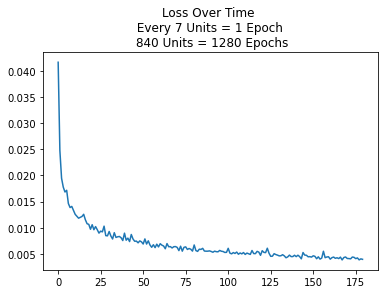

In [7]:
ls = np.array(loss_over_time)
print(np.size(ls))
plt.plot(ls[:])
plt.title("Loss Over Time \n Every 7 Units = 1 Epoch \n 840 Units = 1280 Epochs")
plt.show()

##### Check Generated Dihedrals

In [8]:
for batch_idx, (data, _) in enumerate(train_loader):
        data = utilities.flatten_data(data)
        data = data.to(device)[:, 102:]
        target = utilities.custom_bucketize(data, GLOBAL_NUM_BINS).to(device)
        
        optimizer.zero_grad()
        softmax_X_pred, attn_mats = model(decoder_input=data, return_attention=True) 
        break

In [9]:
print(attn_mats.shape)

torch.Size([1024, 2, 198, 198])


In [10]:
mat1 = attn_mats[0, 0, :, :].cpu().detach().numpy()
mat2 = attn_mats[0, 1, :, :].cpu().detach().numpy()

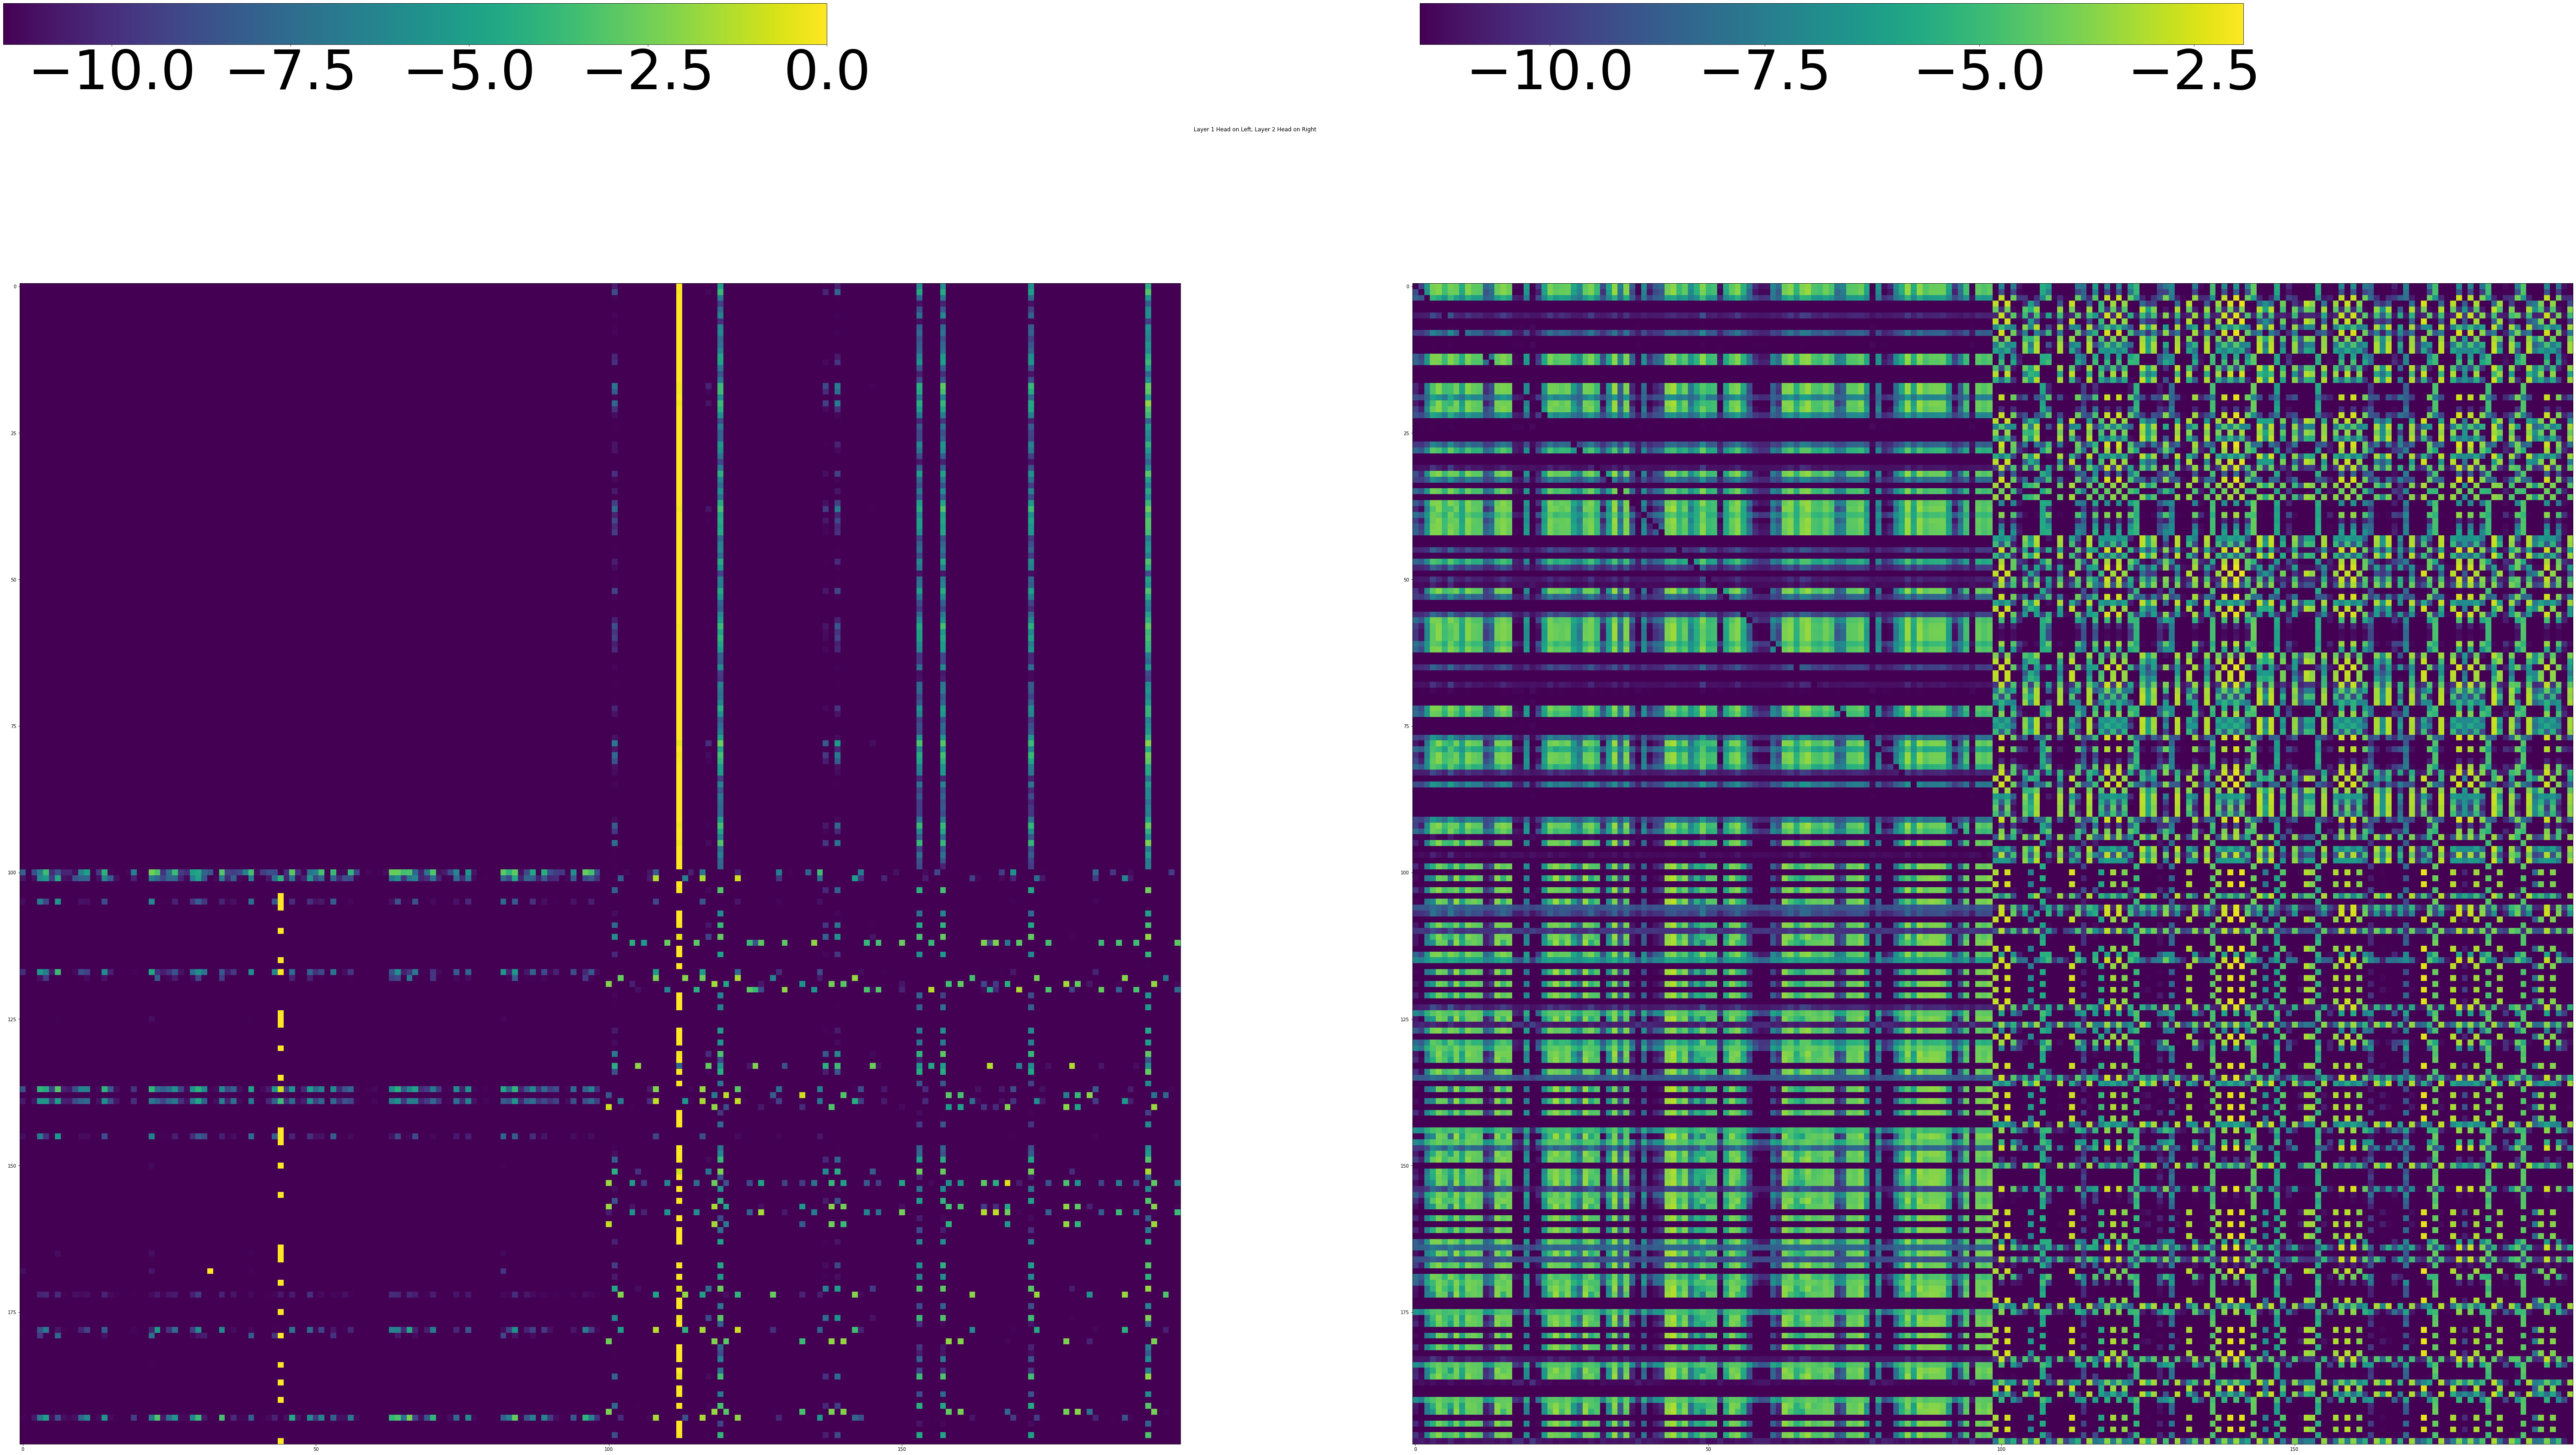

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Layer 1 Head on Left, Layer 2 Head on Right', y=0.95)

fig.set_size_inches(100, 50)

plt.rcParams.update({'font.size': 120})

cax1 = fig.add_axes([0.12, 1, 0.25, 0.025])
cax2 = fig.add_axes([0.55, 1, 0.25, 0.025])

img1 = ax1.imshow(np.log(mat1+0.00001), cmap='viridis')
plt.colorbar(img1, cax=cax1, orientation="horizontal")

img2 = ax2.imshow(np.log(mat2+0.00001), cmap='viridis')
plt.colorbar(img2, cax=cax2, orientation="horizontal")


In [ ]:
for index in range(0, 80, 1):
        mat1 = attn_mats[index, 0, :, :].cpu().detach().numpy()
        mat2 = attn_mats[index, 1, :, :].cpu().detach().numpy()

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Layer 1 Head on Left, Layer 2 Head on Right. Index: ' + str(index), y=0.95)

        fig.set_size_inches(100, 50)

        plt.rcParams.update({'font.size': 80})

        cax1 = fig.add_axes([0.12, 1, 0.25, 0.025])
        cax2 = fig.add_axes([0.55, 1, 0.25, 0.025])

        img1 = ax1.imshow(np.log(mat1+0.00001), cmap='viridis')
        plt.colorbar(img1, cax=cax1, orientation="horizontal")

        img2 = ax2.imshow(np.log(mat2+0.00001), cmap='viridis')
        plt.colorbar(img2, cax=cax2, orientation="horizontal")

In [ ]:
phi_psi = torch.tensor([3, 6, 12, 17, 23, 26, 32, 43, 46, 52, 63, 66, 72, 77, 83, 92]).add(99)
print(len(phi_psi))

mat = torch.zeros([198])
mat[phi_psi[:]] = 1

In [ ]:
matrix = mat.repeat(198, 1)
matrix = matrix + torch.transpose(matrix, 0, 1)

In [ ]:
mat1 = matrix
mat2 = matrix

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Layer 1 Head on Left, Layer 2 Head on Right. Index: ' + str(index), y=0.95)

fig.set_size_inches(100, 50)

plt.rcParams.update({'font.size': 80})

cax1 = fig.add_axes([0.12, 1, 0.25, 0.025])
cax2 = fig.add_axes([0.55, 1, 0.25, 0.025])

img1 = ax1.imshow(np.log(mat1+0.00001), cmap='viridis')
plt.colorbar(img1, cax=cax1, orientation="horizontal")

img2 = ax2.imshow(np.log(mat2+0.00001), cmap='viridis')
plt.colorbar(img2, cax=cax2, orientation="horizontal")

### Closer Look at the First Row

In [ ]:
torch.log(attn_mats[index, 0, :, :])

In [ ]:
device = torch.device("cuda:0")

In [ ]:
mask = torch.ones(attn_mats[index, 0, :, :].cpu().detach().size()[0]).to()
mask = 1 - mask.diag()
sim_vec = torch.nonzero((attn_mats[index, 0, :, :].cpu().detach() >= 0.3)*mask)

In [ ]:
print(sim_vec.shape)

In [ ]:
print(sim_vec.shape)
print(sim_vec)

In [ ]:
phi_psi = torch.tensor([3, 6, 12, 17, 23, 26, 32, 43, 46, 52, 63, 66, 72, 77, 83, 92]).add(99)

In [ ]:
torch.set_printoptions(threshold=10000)

In [ ]:
print(phi_psi)